In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway, ttest_ind, mannwhitneyu, pearsonr

df = pd.read_csv("./data/titanic.csv")


In [ ]:
def get_features_cat_regression(df, target_col, pvalue=0.05):
    '''La funcion tiene como objetivo estudiar la correlación entre la variable objetivo con el resto de columnas y estudiar su independencia.

    '''
    
    if not isinstance(df, pd.DataFrame):
        print("Error: 'df' no es un DataFrame.")
        return None
    if not isinstance(target_col, str):
        print("Error: 'target_col' debe ser un string.")
        return None
    if target_col not in df.columns:
        print(f"Error: '{target_col}' no está en el DataFrame.")
        return None
    if not (0 < pvalue < 1):
        print("Error: 'pvalue' debe estar entre 0 y 1.")
        return None
    
    if not np.issubdtype(df[target_col].dtype, np.number): #Utilizamos issubdtype porque 'df[target_col].dtype' no es un número, sino un objeto dtype y si usamos isinstance aunque sea numérica devuelve error.
        print("Error: 'target_col' no es una variable numérica.")
        return None
    if df[target_col].nunique()/len(df)*100 < 10:
        print("Error: 'target_col' no tiene suficiente cardinalidad para considerarse continua o discreta adecuada.")
        return None
    
    columnas_categoricas = df.select_dtypes(include= ['object','category','bool']).columns.to_list()
    selected_features = []
    for col in columnas_categoricas: 
        if df[col].nunique() ==2:
            categorias = df[col].dropna().unique() #Obtenemos las categorías de la columna (binomial)
            grupo1 = df[df[col] == categorias[0]][target_col].dropna() #Primera categoría
            grupo2 = df[df[col] == categorias[1]][target_col].dropna() #Segunda categoría
            if len(grupo1) > 1 and len(grupo2) >1: #Necesitamos que tenga mas de un elemento para poder hacer el test.
                stats, p = mannwhitneyu(grupo1, grupo2)
            if p < pvalue:
                selected_features.append(col)
        elif df[col].nunique() > 2:
            grupos = df[col].dropna().unique()
            valor_grupo= [df[df[col] == grupo][target_col].dropna() for grupo in grupos]
            if all(len(elementos) > 2 for elementos in valor_grupo) and len(valor_grupo) >= 2:
                stats, p = f_oneway(*valor_grupo)#H0 implica que tienen medias similares y no influye sobre la variable target (son independientes)
                if p < pvalue: #Se rechaza H0 y los grupos tienen una elevada varianza. Cada grupo categórico tiene influencia en la variable target (son dependientes)
                    selected_features.append(col)
    return selected_features







In [22]:
get_features_cat_regression(df, "fare", pvalue= 0.05)

['sex',
 'embarked',
 'class',
 'who',
 'adult_male',
 'deck',
 'embark_town',
 'alive',
 'alone']

In [41]:
def plot_features_cat_regression(df,target_col= "", columns = [], pvalue = 0.05, with_individual_plot = False):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("Por favor, introduce un argumento que sea un DataFrame")
    if not isinstance(target_col,str) or target_col not in df.columns:
        raise ValueError(f"Por favor, revisa que la columna {target_col} introducida existe en el DataFrame.")
    if not isinstance(columns, list):
        raise ValueError("Debes de introducir una lista de columnas")
    missing_cols = [col for col in columns if col not in df.columns]
    if missing_cols:
        raise ValueError("Revisa las columnas, no se encuentran en el DataFrame")
    if not (0 < pvalue < 1):
        raise ValueError("El 'pvalue' introducido debe de estar entre 0 y 1")
    if not isinstance(with_individual_plot, bool):
        raise ValueError("El valor de este parámetro solo puede ser True or False")
    if not np.issubdtype(df[target_col].dtype, np.number):
        print("Error: 'target_col' no es una variable numérica.")
        return None
    if df[target_col].nunique()/len(df)*100 < 10:
        print("Error: 'target_col' no tiene suficiente cardinalidad para regresión.")
        return None
    
    selected_features = []

    if len(columns) == 0: 
        columns = [col for col in df.select_dtypes(include=np.number).columns if col != target_col]
        for col in columns:
            subset = df[[target_col, col]].replace([np.inf, -np.inf], np.nan).dropna() #Necesitamos esto para quitar infinitos y nulos, para evitar fallo en el coeficiente de Pearson
            corr, p= pearsonr(subset[target_col], subset[col])
            if p < pvalue: #correlación estadísticamente significativa
                selected_features.append(col)
                sns.scatterplot(data=df, x=target_col, y= col)
                plt.title(f'Relación entre {target_col} y {col}')
                plt.tight_layout()
                plt.show()

    if len(columns) > 0:
        columnas_categoricas = [col for col in columns if df[col].dtype in ['object', 'category', 'bool']]
    
        for col in columnas_categoricas: 
            if df[col].nunique() ==2:
                categorias = df[col].dropna().unique() #Obtenemos las categorías de la columna (binomial)
                grupo1 = df[df[col] == categorias[0]][target_col].dropna() #Primera categoría
                grupo2 = df[df[col] == categorias[1]][target_col].dropna() #Segunda categoría
                if len(grupo1) > 1 and len(grupo2) >1: #Necesitamos que tenga mas de un elemento para poder hacer el test.
                    stats, p = mannwhitneyu(grupo1, grupo2)
                if p < pvalue:
                    selected_features.append(col)
            elif df[col].nunique() > 2:
                grupos = df[col].dropna().unique()
                valor_grupo= [df[df[col] == grupo][target_col].dropna() for grupo in grupos]
                if all(len(elementos) > 2 for elementos in valor_grupo) and len(valor_grupo) >= 2:
                    stats, p = f_oneway(*valor_grupo)#H0 implica que tienen medias similares y no influye sobre la variable target (son independientes)
                    if p < pvalue: #Se rechaza H0 y los grupos tienen una elevada varianza. Cada grupo categórico tiene influencia en la variable target (son dependientes)
                        selected_features.append(col)
                        sns.histplot(data = df, x=target_col, hue = col)
                        plt.title(f'Histograma entre {target_col} y {col}')
                        plt.tight_layout()
                        plt.show()
    return selected_features

    
    
    

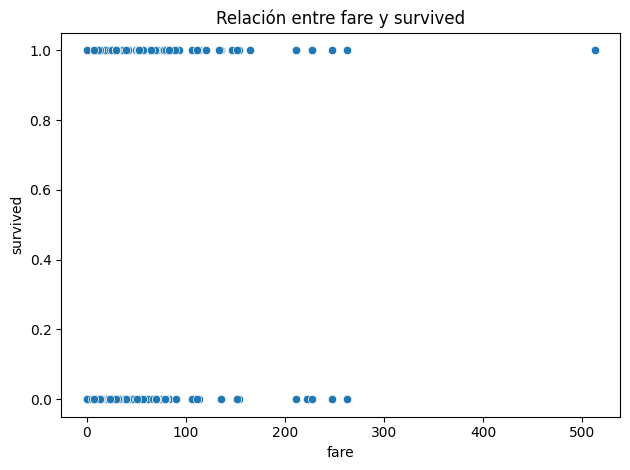

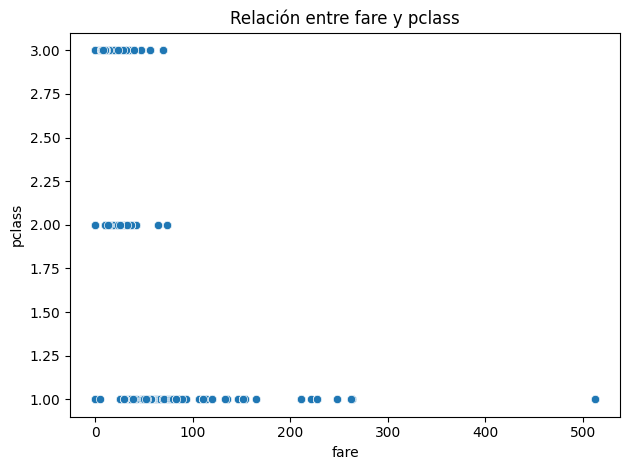

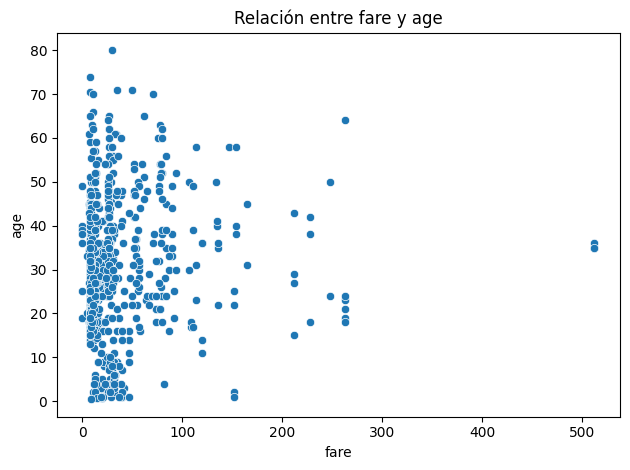

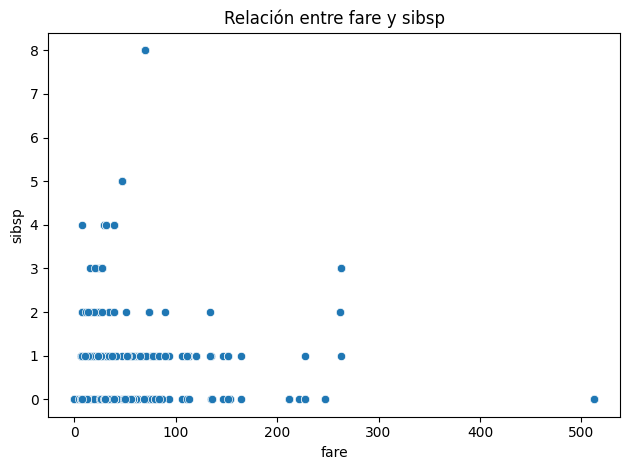

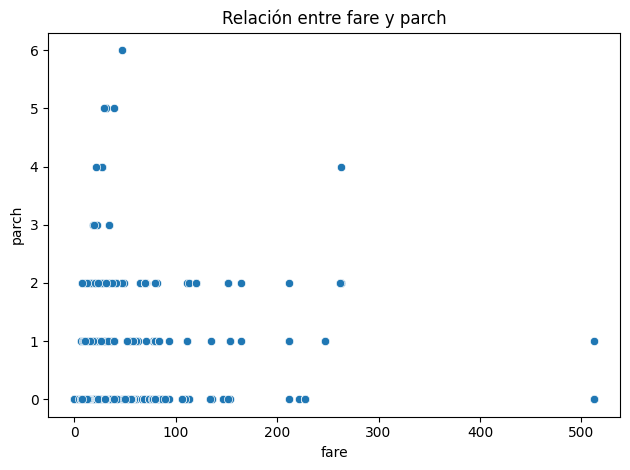

['survived', 'pclass', 'age', 'sibsp', 'parch']

In [42]:
plot_features_cat_regression(df, target_col="fare")